In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt


In [12]:
# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')

# Extract state and action dimensions
state_dim = env.observation_space.shape[0]  # 4 for CartPole
action_dim = env.action_space.n  # 2 for CartPole (discrete actions)

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity

    def add(self, experience):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states = torch.tensor([self.buffer[i][0] for i in batch], dtype=torch.float32).to(device)
        actions = torch.tensor([self.buffer[i][1] for i in batch], dtype=torch.long).to(device)
        rewards = torch.tensor([self.buffer[i][2] for i in batch], dtype=torch.float32).to(device)
        next_states = torch.tensor([self.buffer[i][3] for i in batch], dtype=torch.float32).to(device)
        dones = torch.tensor([self.buffer[i][4] for i in batch], dtype=torch.float32).to(device)
        return states, actions, rewards, next_states, dones


In [5]:
class ActorDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        logits = self.layer3(x)
        action_probs = torch.softmax(logits, dim=-1)
        return action_probs


In [6]:
class CriticDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim, num_atoms=51):
        super(CriticDiscrete, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim * num_atoms)
        self.num_atoms = num_atoms

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        logits = self.layer3(x)
        logits = logits.view(-1, self.num_atoms)
        return torch.softmax(logits, dim=-1)


In [7]:
class D4PGAgentDiscrete:
    def __init__(self, state_dim, action_dim, num_atoms=51, z_min=-10, z_max=10):
        self.actor = ActorDiscrete(state_dim, action_dim).to(device)
        self.actor_target = ActorDiscrete(state_dim, action_dim).to(device)
        self.critic = CriticDiscrete(state_dim, action_dim, num_atoms).to(device)
        self.critic_target = CriticDiscrete(state_dim, action_dim, num_atoms).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.tau = 0.005

        # Distributional D4PG parameters
        self.num_atoms = num_atoms
        self.z_min = z_min
        self.z_max = z_max
        self.delta_z = (z_max - z_min) / (num_atoms - 1)
        self.z = torch.linspace(z_min, z_max, num_atoms).to(device)

        # Copy weights to target networks
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

    def select_action(self, state):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action_probs = self.actor(state).detach().cpu().numpy()[0]
            action = np.random.choice(len(action_probs), p=action_probs)
        return action

    def train(self, batch_size=64):
        # Training logic as defined previously
        pass


In [8]:
def train_d4pg(env_name='CartPole-v1', episodes=1000, batch_size=64, warmup_steps=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = D4PGAgentDiscrete(state_dim, action_dim)

    rewards = []
    for episode in range(episodes):
        state, _ = env.reset(seed=42)
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            reward = np.clip(reward, -1.0, 1.0)
            agent.replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            episode_reward += reward

            if len(agent.replay_buffer.buffer) >= warmup_steps:
                agent.train(batch_size=batch_size)

        rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return rewards


In [14]:
def evaluate_d4pg(agent, env_name='CartPole-v1', episodes=10):
    env = gym.make(env_name)
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset(seed=42)  # Adjust to unpack properly
        done = False
        episode_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Combine termination and truncation logic
            episode_reward += reward
            state = next_state  # Update state

        rewards.append(episode_reward)
        print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")

    print(f"Average Reward: {np.mean(rewards)}")
    return rewards


In [10]:
def plot_rewards(rewards, title="Training Rewards for D4PG"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# rewards = train_d4pg()
# plot_rewards(rewards)


Episode 1: Reward = 10.0
Episode 2: Reward = 13.0
Episode 3: Reward = 25.0
Episode 4: Reward = 10.0
Episode 5: Reward = 15.0
Episode 6: Reward = 18.0
Episode 7: Reward = 12.0
Episode 8: Reward = 13.0
Episode 9: Reward = 23.0
Episode 10: Reward = 44.0
Episode 11: Reward = 29.0
Episode 12: Reward = 20.0
Episode 13: Reward = 14.0
Episode 14: Reward = 26.0
Episode 15: Reward = 42.0
Episode 16: Reward = 19.0
Episode 17: Reward = 37.0
Episode 18: Reward = 10.0
Episode 19: Reward = 11.0
Episode 20: Reward = 25.0
Episode 21: Reward = 23.0
Episode 22: Reward = 19.0
Episode 23: Reward = 16.0
Episode 24: Reward = 14.0
Episode 25: Reward = 12.0
Episode 26: Reward = 31.0
Episode 27: Reward = 12.0
Episode 28: Reward = 16.0
Episode 29: Reward = 31.0
Episode 30: Reward = 15.0
Episode 31: Reward = 38.0
Episode 32: Reward = 21.0
Episode 33: Reward = 32.0
Episode 34: Reward = 31.0
Episode 35: Reward = 40.0
Episode 36: Reward = 14.0
Episode 37: Reward = 9.0
Episode 38: Reward = 12.0
Episode 39: Reward = 3

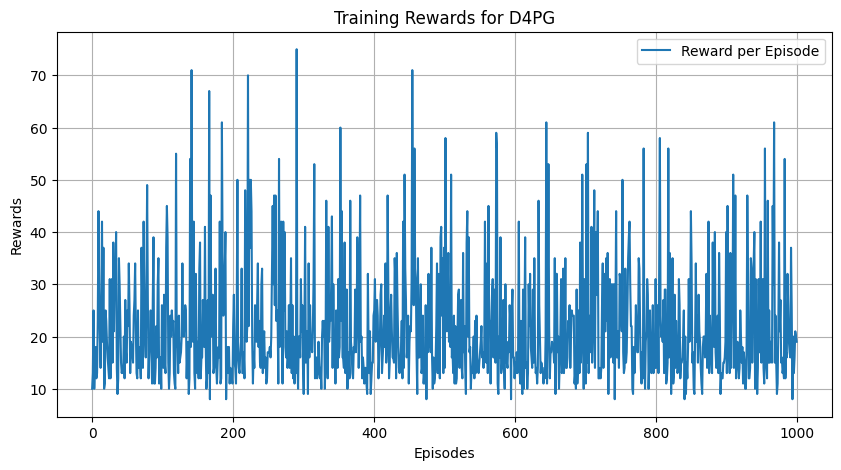

Evaluation Episode 1: Reward = 28.0
Evaluation Episode 2: Reward = 27.0
Evaluation Episode 3: Reward = 17.0
Evaluation Episode 4: Reward = 22.0
Evaluation Episode 5: Reward = 15.0
Evaluation Episode 6: Reward = 38.0
Evaluation Episode 7: Reward = 17.0
Evaluation Episode 8: Reward = 16.0
Evaluation Episode 9: Reward = 14.0
Evaluation Episode 10: Reward = 15.0
Average Reward: 20.9


In [15]:
if __name__ == "__main__":
    # Train the agent
    rewards = train_d4pg()

    # Plot the rewards
    plot_rewards(rewards)

    # Evaluate the agent
    agent = D4PGAgentDiscrete(state_dim=4, action_dim=2)  # Replace with actual dimensions
    evaluate_d4pg(agent)
